In [1]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit

## Reading the Files

### Soft Band

In [2]:
result_s= fits.open('Soft_band/acisf11785_001N021_r0041s_lc3.fits')
print(result_s.info())
resolution_s = result_s[1].header['TIMEDEL']

Filename: Soft_band/acisf11785_001N021_r0041s_lc3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU    163   1881R x 5C   [1D, 1D, 1D, 1D, 1D]   
  2  BKGLIGHTCURVE    1 BinTableHDU    169   1881R x 5C   [1D, 1D, 1D, 1D, 1D]   
None


### Hard Band

In [4]:
#Observation 
result_h= fits.open('Hard_band/acisf11785_001N021_r0041h_lc3.fits')
print(result_h.info())
resolution_h = result_h[1].header['TIMEDEL']

Filename: Hard_band/acisf11785_001N021_r0041h_lc3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU    163   1881R x 5C   [1D, 1D, 1D, 1D, 1D]   
  2  BKGLIGHTCURVE    1 BinTableHDU    169   1881R x 5C   [1D, 1D, 1D, 1D, 1D]   
None


## Extracting the Data

In [5]:
%matplotlib inline
#Soft Band
lc_s = result_s[1].data #Lightcurve
bg_s = result_s[2].data #Lightcurve

#Hard Band
lc_h = result_h[1].data #Lightcurve
bg_h = result_h[2].data #Lightcurve


#arrays
#Soft Band
time_s = lc_s['Time']
count_rate_s = lc_s['COUNT_RATE']
count_rate_err_s = lc_s['COUNT_RATE_ERR']
bg_count_rate_s = bg_s['COUNT_RATE']
bg_count_rate_err_s = bg_s['COUNT_RATE_ERR']

#Hard Band
time_h = lc_h['Time']
count_rate_h = lc_h['COUNT_RATE']
count_rate_err_h = lc_h['COUNT_RATE_ERR']
bg_count_rate_h = bg_h['COUNT_RATE']
bg_count_rate_err_h = bg_h['COUNT_RATE_ERR']

#Background Subtraction
#Soft Band
net_count_rate_s = count_rate_s - bg_count_rate_s
net_err_s = [(count_rate_err_s[i]**2 + bg_count_rate_err_s[i]**2)**0.5 for i in range(len(bg_count_rate_s))]

#Hard Band
net_count_rate_h = count_rate_h - bg_count_rate_h
net_err_h = [(count_rate_err_h[i]**2 + bg_count_rate_err_h[i]**2)**0.5 for i in range(len(bg_count_rate_h))]

#starting time from zero(Only when both the band time axes are identical)
dt = time_s - time_s[0]

#Same resolution
resolution = resolution_h

## Representing the Data

### Hardness Ratio

In [6]:
time = []
hardness_ratio = []
abs_err_HR = [] #absolute error in Hardness Ratio
rel_err_HR = [] #Relative error in Hardness Ratio
abs_err_num = []  #denominator numerator same absolute err
rel_err_num = []
rel_err_den = []
j = 0
for i in range(len(dt)):
    if (net_count_rate_h[i] >= 0) and (net_count_rate_s[i] >=0) :
        time.append(dt[i])
        hardness_ratio.append((net_count_rate_h[i]-net_count_rate_s[i])/(net_count_rate_h[i]+net_count_rate_s[i]))
        abs_err_num.append((net_err_h[j]**2 + net_err_s[j]**2)**0.5)
        rel_err_num.append(abs_err_num[j]/(net_count_rate_h[j]-net_count_rate_s[j]))
        rel_err_den.append(abs_err_num[j]/(net_count_rate_h[j]+net_count_rate_s[j]))
        rel_err_HR.append((rel_err_num[j]**2 + rel_err_den[j]**2)**0.5)
        abs_err_HR.append(hardness_ratio[j]*rel_err_HR[j])
        j+=1
len(rel_err_den)

1743

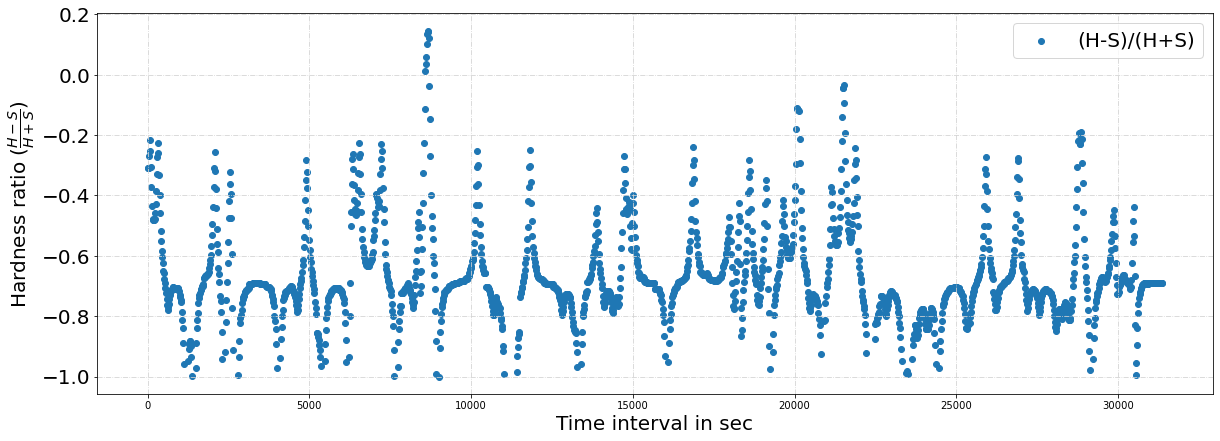

In [7]:
plt.figure(figsize = [20,7], facecolor = 'w')
plt.scatter(time, hardness_ratio, label = '(H-S)/(H+S)')
#plt.errorbar(dt_b_1,count_rate_b_1, count_rate_err_b_1)
plt.grid(color = 'lightgrey', ls = '-.')
plt.xlabel('Time interval in sec', fontsize = 20)
plt.ylabel('Hardness ratio ($\\frac{H-S}{H+S}$)', fontsize =20)
#plt.title(f'plot of {file_name}', fontsize = 20)
#plt.text(10000,2.8e-5, s = f'resolution = {resolution} s', fontsize = 20)
#plt.xlim(0,40000)
#plt.ylim(0,0.0009)
plt.legend(fontsize = 20)
y = plt.yticks(fontsize = 20)

## Binning

Binned resolution is 350.36283749342397s


Text(0, 0.3, 'Resolution = 350.36283749342397 s')

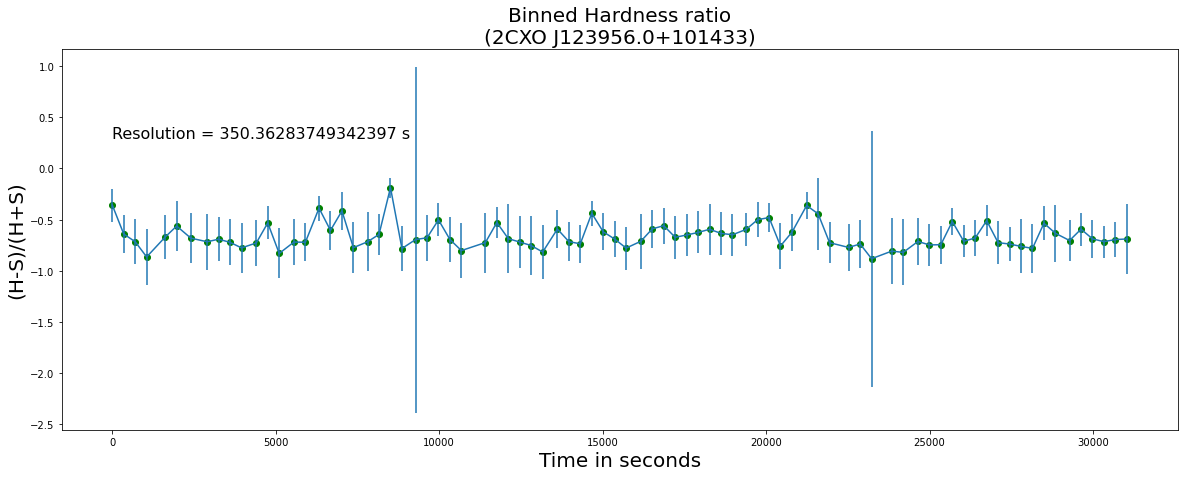

In [8]:
n_total = 1743 #Total data points
n_bin = 83 #Number of bins
bin_size = int(n_total/n_bin) #Bin size in units of data points
binned_resolution = bin_size*resolution
print(f'Binned resolution is {binned_resolution}s')
#print(bin_size)
HR_binned = np.zeros(n_bin)
time_binned = np.zeros(n_bin)
err_binned = np.zeros(n_bin)

for i in range(n_bin):
    time_binned[i] = time[bin_size*i]
for i in range(n_bin):
    sum_err_sq = 0
    for j in range((bin_size)):
        #summing and averaging all the counts 
        HR_binned[i] += hardness_ratio[j+i*bin_size]/bin_size
        #summing square errors
        sum_err_sq += abs_err_HR[j+i*bin_size]**2 
    err_binned[i] = (sum_err_sq/bin_size**2)**0.5 

#Percentage error before and after binning
"""err_percent_binned_b_1 = []
err_percent_b_1 = []
for i in range(n_bin_b_1):
    err_percent_binned_b_1.append((err_binned_b_1[i]/cr_binned_b_1[i])*100)
for i in range(n_total_b_1):
    err_percent_b_1.append((net_err_b_1[i]/net_count_rate_b_1[i])*100)
""" 
plt.figure(figsize = [20,7], facecolor = 'w')
plt.scatter(time_binned,HR_binned,c='green')
plt.errorbar(time_binned,HR_binned,err_binned)
plt.title('Binned Hardness ratio\n(2CXO J123956.0+101433)', fontsize = 20)
plt.xlabel('Time in seconds', fontsize = 20)
plt.ylabel('(H-S)/(H+S)', fontsize = 20)
plt.text(0,0.3,s=f'Resolution = {binned_resolution} s', fontsize = 16)

/tmp/ipykernel_7646/2768752277.py:33: RuntimeWarning: invalid value encountered in double_scalars
  F_var.append((Nxs_var[i]**0.5)*100)


Text(0.5, 0, 'Time in seconds')

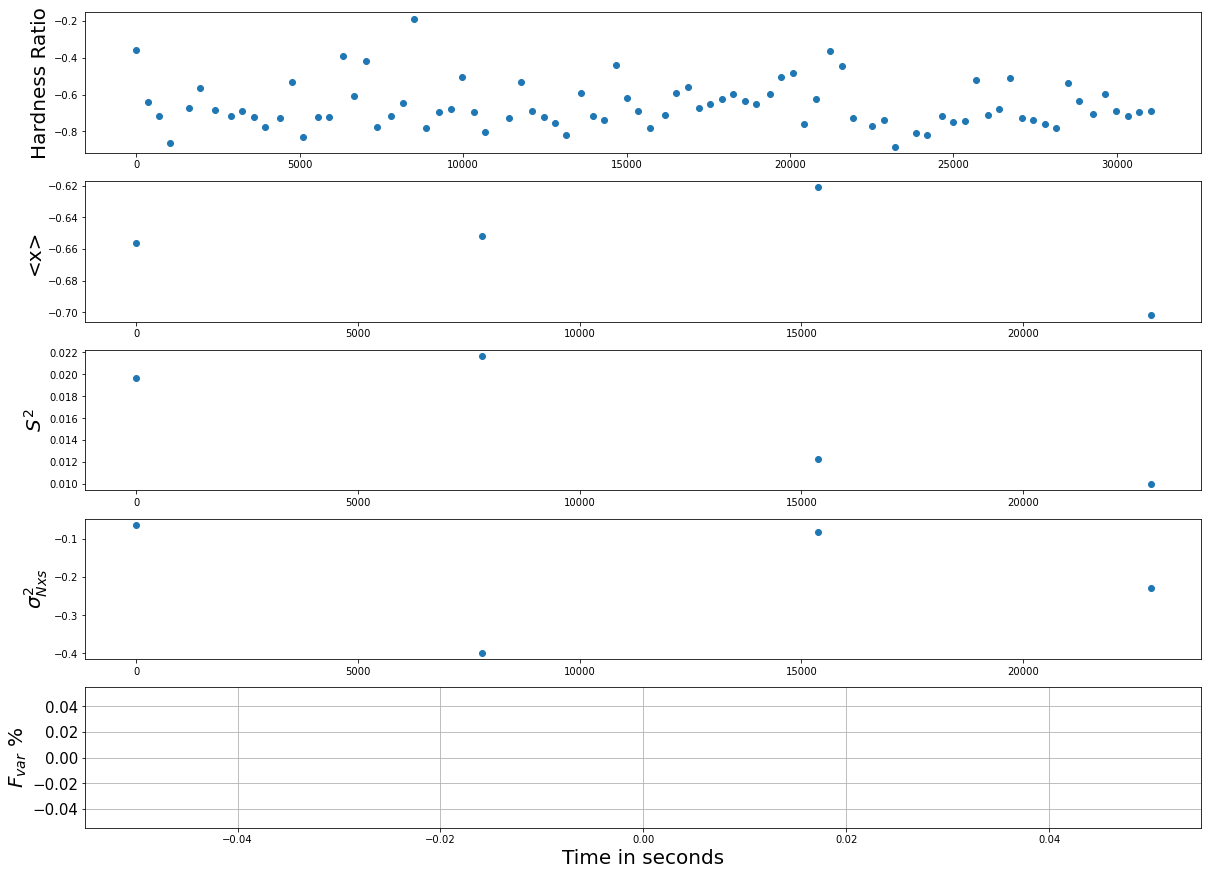

In [15]:
#MAKING AVG FLUX OF EVERY 20 POINTS
n_binned = 83#Total data points(already binned)
bin_size = 20#size of the bin in data points
n_points = int(n_binned/bin_size) #no. of data points

#print(n_points)
t_avg = [] #time for avg
HR_avg = [] #avg Hardness ratio
for i in range(n_points):
    t_avg.append(time_binned[i*bin_size])
    #print(i,i*25)
    sum = 0
    for j in range(bin_size):
        sum += HR_binned[j+i*bin_size]
    HR_avg.append(sum/bin_size)
    
var = [] #variance
xs_var = [] #excess variance
Nxs_var = [] #Normalized excess variance
F_var = []
for i in range(n_points):
    sum = 0
    sum_err_sq = 0 #sum of squared err
    for j in range(0,bin_size):
        sum += (HR_binned[j+i*bin_size] - HR_avg[i])**2
        sum_err_sq += (err_binned[j+i*bin_size])**2
    avg_sum_err_sq = sum_err_sq/bin_size
    #print('err ',avg_sum_err_sq)
    #print('var ',sum/19)
    var.append(sum/(bin_size - 1))
    xs_var.append(var[i] - avg_sum_err_sq)
    Nxs_var.append(xs_var[i]/HR_avg[i]**2)
    F_var.append((Nxs_var[i]**0.5)*100)
   
#EXPECTATION VALUE OF VARIANCE
'''
expect_var = []
t_further = []
for i in range(7):
    sum = 0
    t_further.append(t_avg[i*20])
    for j in range(20):
        sum += var[j+i*20]
    expect_var.append(sum/20)
'''    
#PLOTTING
plt.figure(figsize = [20,15], facecolor = 'w')
ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)
ax1.scatter(time_binned, HR_binned)
ax1.set_ylabel('Hardness Ratio', fontsize = 20)
ax2.scatter(t_avg, HR_avg)
ax2.set_ylabel('<x>', fontsize = 20)
ax3.scatter(t_avg, var)
ax3.set_ylabel('$S^2$', fontsize = 20)
y = plt.yticks(fontsize = 15)
#ax3.set_yscale('log')
ax4.scatter(t_avg, Nxs_var)
ax4.set_ylabel('$σ_{Nxs}^2$', fontsize = 20)
plt.grid(True)
y = plt.yticks(fontsize = 15)
#ax4.set_yscale('log')
ax5.scatter(t_avg, F_var)
ax5.set_ylabel('$F_{var} $ %', fontsize = 20)
y = plt.yticks(fontsize = 15)
plt.xlabel('Time in seconds', fontsize = 20)

Text(0.5, 1.0, 'Hardness ratio distribution of\n2CXO J123956.0+101433')

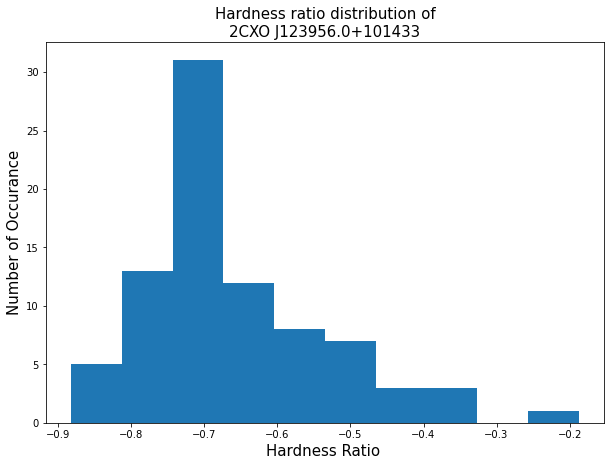

In [13]:
plt.figure(figsize = [10,7], facecolor = 'w')
plt.hist(HR_binned, bins = 10)
#plt.xscale('logit')
plt.xlabel('Hardness Ratio ', fontsize = 15)
plt.ylabel('Number of Occurance', fontsize = 15)
plt.title('Hardness ratio distribution of\n2CXO J123956.0+101433', fontsize = 15)

### Gaussian ==>
# $ y = ae^{-\frac{(x-b)^2}{2c^2}}$

### Lorrentzian ==>
# $ y = a\frac{\frac{1}{2}\Gamma}{(x - x_0)^2 + (\frac{1}{2}\Gamma)^2}$

Goodness of fit for Gaussian nan per dof
Goodness of fit for Lorrentzian nan per dof


/tmp/ipykernel_7646/287867634.py:33: RuntimeWarning: invalid value encountered in log10
  least_sq_g += (gaussian(np.log10(x[i]),param_g[0],param_g[1],param_g[2])-y[i])**2
/tmp/ipykernel_7646/287867634.py:34: RuntimeWarning: invalid value encountered in log10
  least_sq_l += (lorrentzian(np.log10(x[i]),param_l[0],param_l[1],param_l[2])-y[i])**2


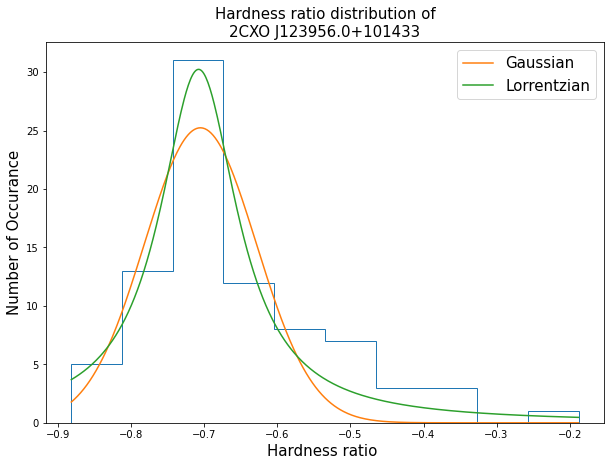

In [14]:
plt.figure(figsize = [10,7], facecolor = 'w')
distribution = plt.hist(HR_binned, bins = 10, histtype = 'step')
x = []
y = []
for i in range(len(distribution[0])):
    x_temp = np.linspace(distribution[1][i], distribution[1][i+1], 50)
    for j in range(len(x_temp)):
        x.append(x_temp[j])
        y.append(distribution[0][i])

def gaussian(x,a,b,c):
    exponent = -((x-b)**2/(2*c**2))
    return a*np.exp(exponent)

def lorrentzian(x,a,gamma,x_0):
    fraction = (0.5*gamma)/((x-x_0)**2 + (0.5*gamma)**2)
    result = a*fraction
    return result

param_g, pcov_g = curve_fit(gaussian, x,y)
param_l, pcov_l = curve_fit(lorrentzian, x,y)
plt.plot(x,gaussian(x,param_g[0],param_g[1],param_g[2]), label = 'Gaussian')
plt.plot(x,lorrentzian(x,param_l[0],param_l[1],param_l[2]), label = 'Lorrentzian')
#plt.xscale('logit')
plt.legend(fontsize = 15)
plt.xlabel('Hardness ratio ', fontsize = 15)
plt.ylabel('Number of Occurance', fontsize = 15)
plt.title('Hardness ratio distribution of\n2CXO J123956.0+101433', fontsize = 15)

least_sq_g = 0
least_sq_l = 0
for i in range(len(x)):
    least_sq_g += (gaussian(np.log10(x[i]),param_g[0],param_g[1],param_g[2])-y[i])**2
    least_sq_l += (lorrentzian(np.log10(x[i]),param_l[0],param_l[1],param_l[2])-y[i])**2
    
dof_g = len(x)-3
dof_l = len(x)-3
print(f'Goodness of fit for Gaussian {least_sq_g/dof_g} per dof')
print(f'Goodness of fit for Lorrentzian {least_sq_l/dof_l} per dof')